# Combining words using pdfplumber functions, checking checkboxes via write to pdf
- chars ---(filter)---> words ----> combined words
- extract_words method modified as combine(obj)

### TODO:
- parameters?? (x_tolerence, y_tolerence, font size..)

In [2]:
import pdfplumber
from pdfplumber.utils import cluster_objects, objects_to_bbox, extract_words
from operator import itemgetter
import itertools
from decimal import Decimal
import pandas as pd

In [3]:

pdf = pdfplumber.open("files/ex1.pdf")
page = pdf.pages[1]
chars = page.chars

### Chars ---> filtered chars  (optional, pdf dependent)

In [4]:
chars_df = pd.DataFrame(chars)

In [5]:
fonts = chars_df['fontname'].unique()  # different font types
sizes = chars_df['size'].unique()       # different font sizes

In [6]:
fonts

array(['ABCDEE+Calibri', 'ABCDEE+Calibri,Italic', 'Arial,Bold',
       'ABCDEE+Calibri Light', 'ABCDEE+Calibri,Bold',
       'ABCDEE+Arial Narrow', 'ABCDEE+Arial Narrow,Bold',
       'ABCDEE+Calibri,BoldItalic'], dtype=object)

In [7]:
sizes

array([Decimal('9.022'), Decimal('18.776'), Decimal('12.005'),
       Decimal('10.610'), Decimal('10.008'), Decimal('11.019'),
       Decimal('16.903'), Decimal('9.388')], dtype=object)

In [8]:
import itertools

c = list(itertools.product(fonts, sizes))
len(c)

64

In [9]:
### TODO: adaptive??
#chars_filtered = chars_df[(chars_df['fontname'] == 'ArialMT') & (chars_df['size'] == Decimal('8.555'))]
#chars_filtered = chars_df[chars_df['size'] == Decimal('8.555')]

#chars_filtered = chars_df[chars_df['fontname'] == 'Arial-ItalicMT']

##declude the igrenc blank spaces -- genel olarak bu font hep
chars_filtered = chars_df[chars_df['fontname'] != 'ABCDEE+Verdana-Bold']


In [10]:
chars_filtered = chars_filtered.to_dict(orient="records")

### Chars --> words

In [11]:
### words from only filtered chars, with original extract_words function
words = extract_words(chars_filtered)   ### combine(chars,"chars") also works

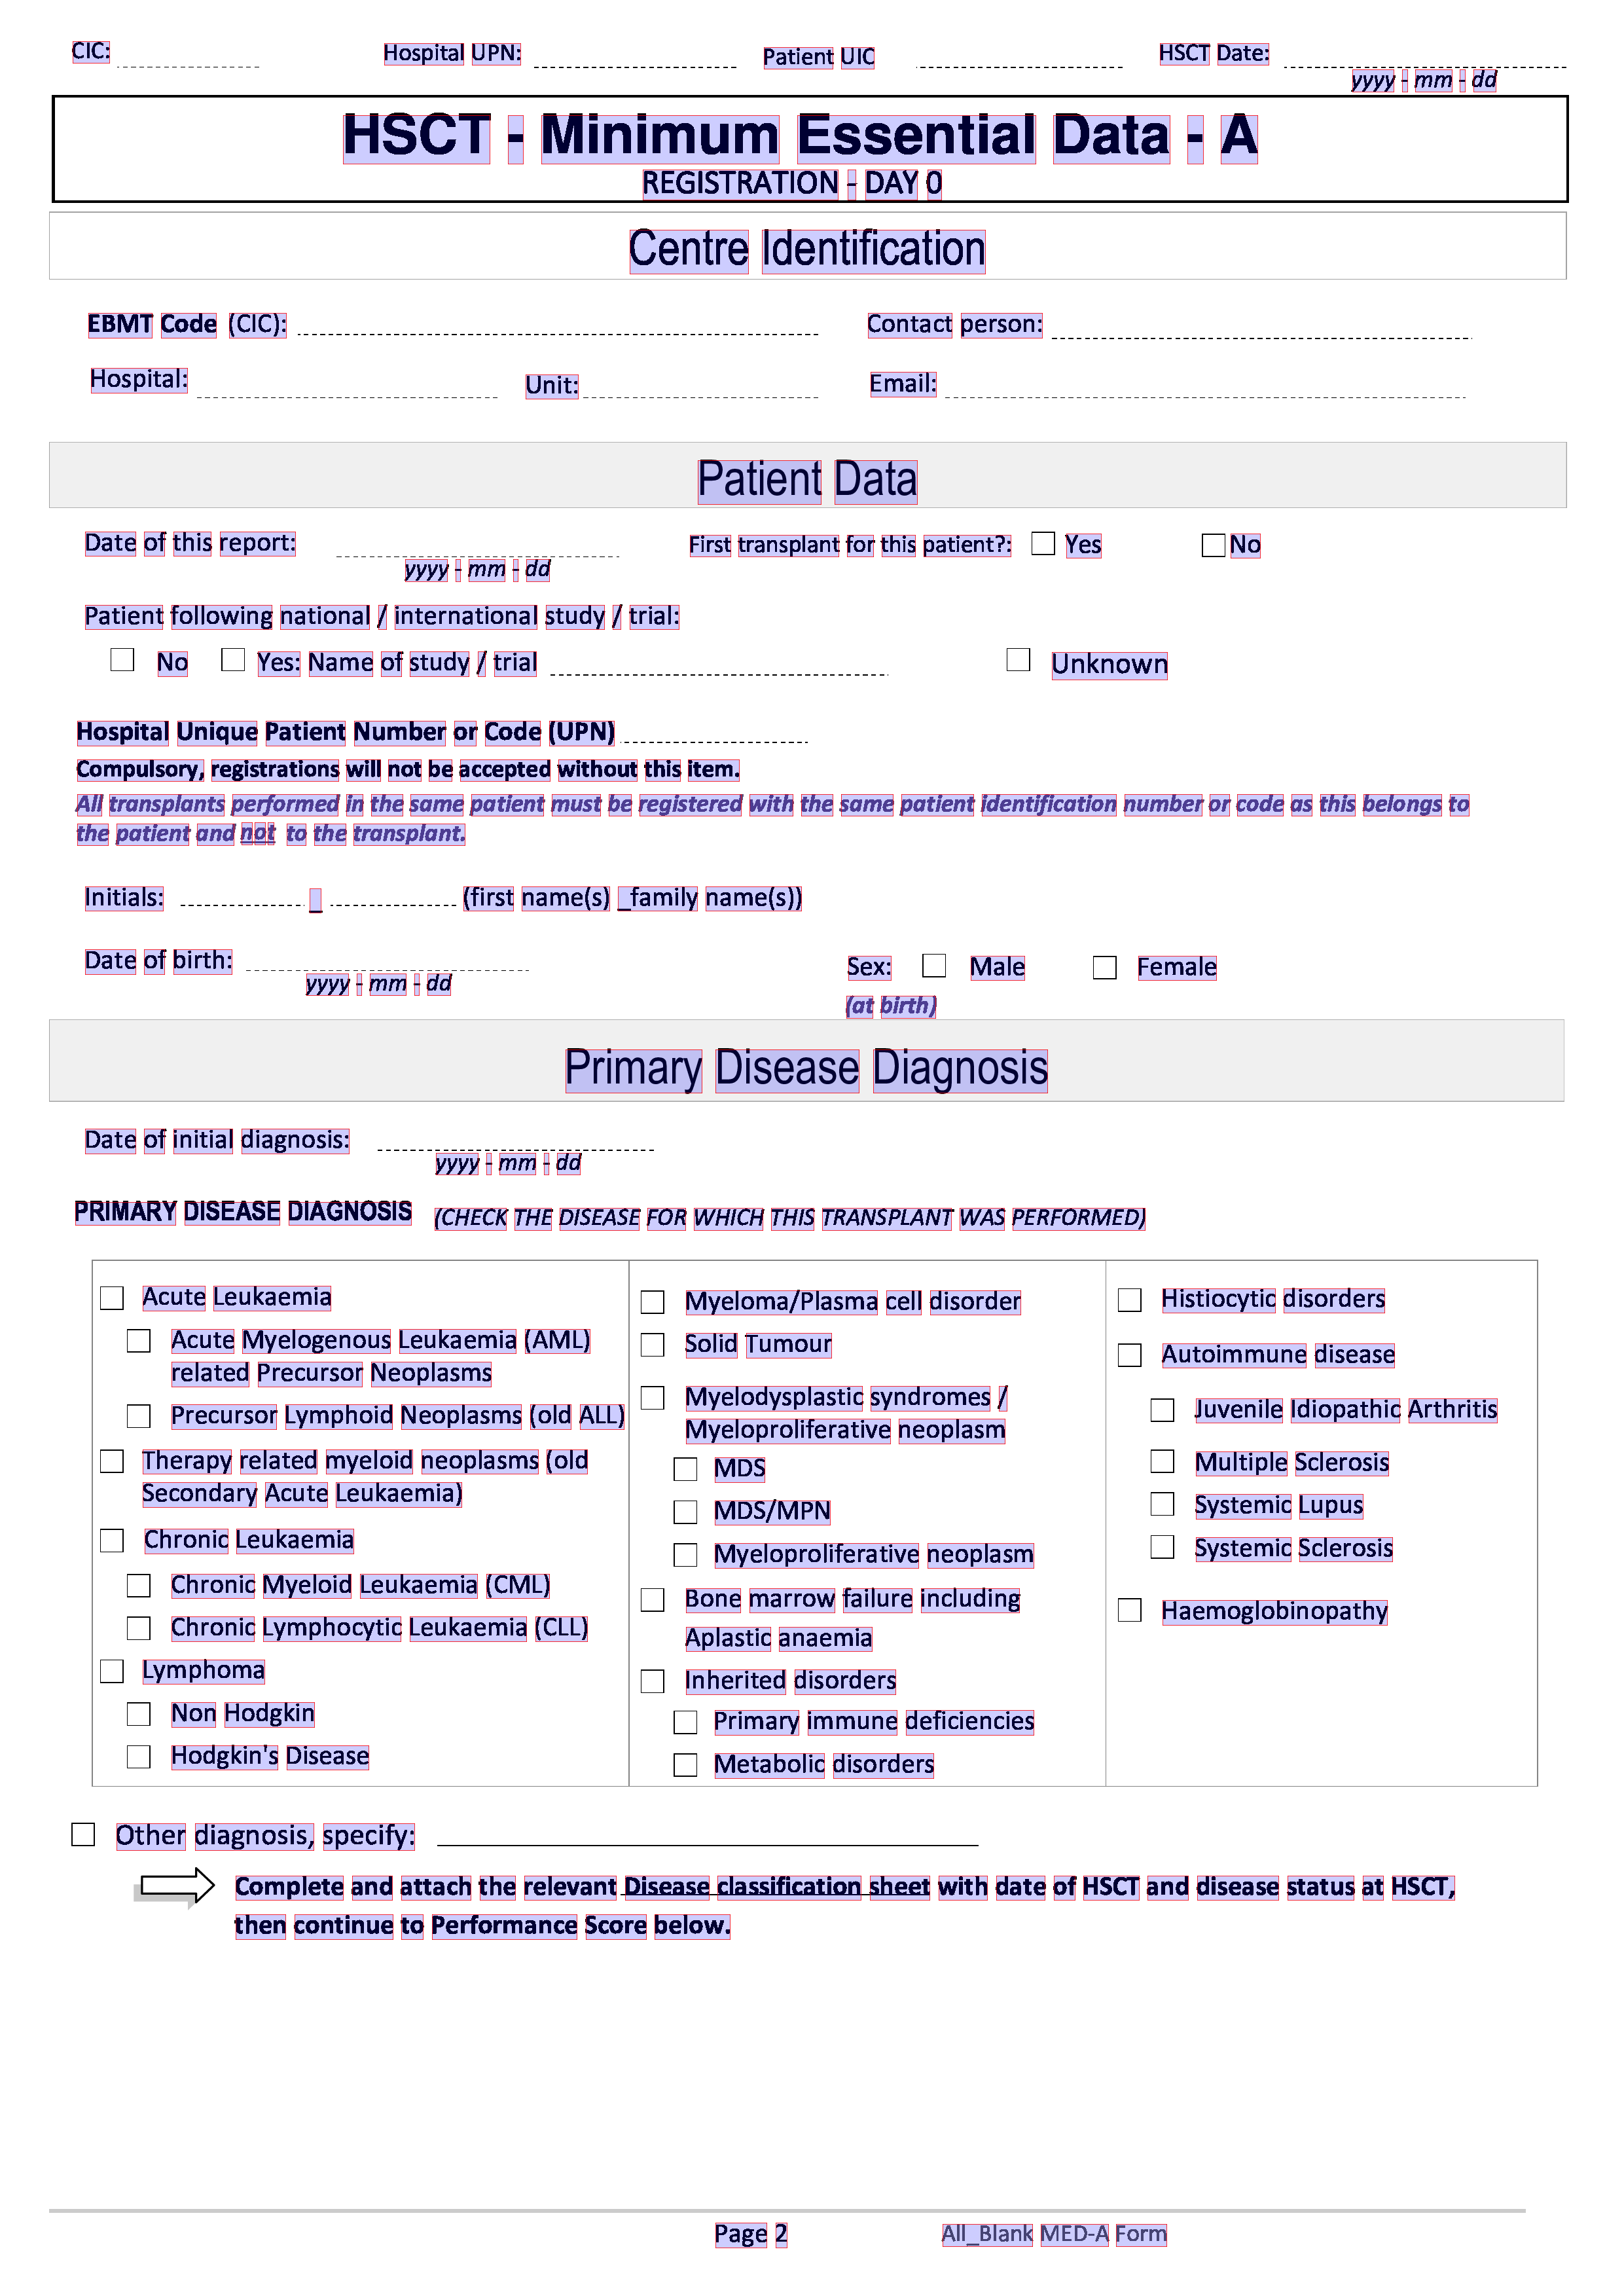

In [12]:
im = page.to_image(resolution=300)
im.draw_rects(words)

### General combination function (adopted from pdfplumber)

In [13]:
def combine(obj, attr, x_tolerance=3, y_tolerance=3, keep_blank_chars=False):
    """
    obj: char list or words list, in pdfplumber format
    attr: "chars" or "words", denoting what to combine
    """

    def process_word_chars(chars):
            x0, top, x1, bottom = objects_to_bbox(chars)
            return {
                "x0": x0,
                "x1": x1,
                "top": top,
                "bottom": bottom,
                "text": " ".join(map(itemgetter("text"), chars))
            }

    def get_line_words(chars, tolerance=3):
        get_text = itemgetter("text")
        chars_sorted = sorted(chars, key=itemgetter("x0"))
        words = []
        current_word = []

        for char in chars_sorted:
            if not keep_blank_chars and get_text(char).isspace():
                if len(current_word) > 0:
                    words.append(current_word)
                    current_word = []
                else: pass
            elif len(current_word) == 0:
                current_word.append(char)
            else:
                last_char = current_word[-1]
                if char["x0"] > (last_char["x1"] + tolerance):
                    words.append(current_word)
                    current_word = []
                current_word.append(char)

        if len(current_word) > 0:
            words.append(current_word)
        processed_words = list(map(process_word_chars, words))
        return processed_words
    
    ### cluster_objects requires different things for combining chars/words
    if attr == "chars":
        attr = "doctop"
    elif attr == "words":
        attr = "top"
    
    clusters = cluster_objects(obj, attr, y_tolerance) 
    nested = [ get_line_words(line_chars, tolerance=x_tolerance)
            for line_chars in clusters ]

    combined_objs = list(itertools.chain(*nested))
    return combined_objs


### words --> combined_words

In [14]:
### TODO: tolerance parameters??
combined_words = combine(words, "words", 
                         x_tolerance=6, ##sometimes 6 is better, 8, 10
                         y_tolerance=5, 
                         keep_blank_chars=False)

#combined_words[:25]

for font, size in list(itertools.product(fonts, sizes)):
    print('-'*30,'font:',font,'-'*30)
    print('-'*30,'size:',size,'-'*30)
    chars_filtered = chars_df[(chars_df['fontname'] == font) & (chars_df['size'] == size)]
    chars_filtered = chars_filtered.to_dict(orient="records")
    words = extract_words(chars_filtered)
    
    combined_words = combine(words, "words", 
                         x_tolerance=10, 
                         y_tolerance=5, 
                         keep_blank_chars=False)
    im = page.to_image(resolution=300)
    im.draw_rects(combined_words)
    display(im)

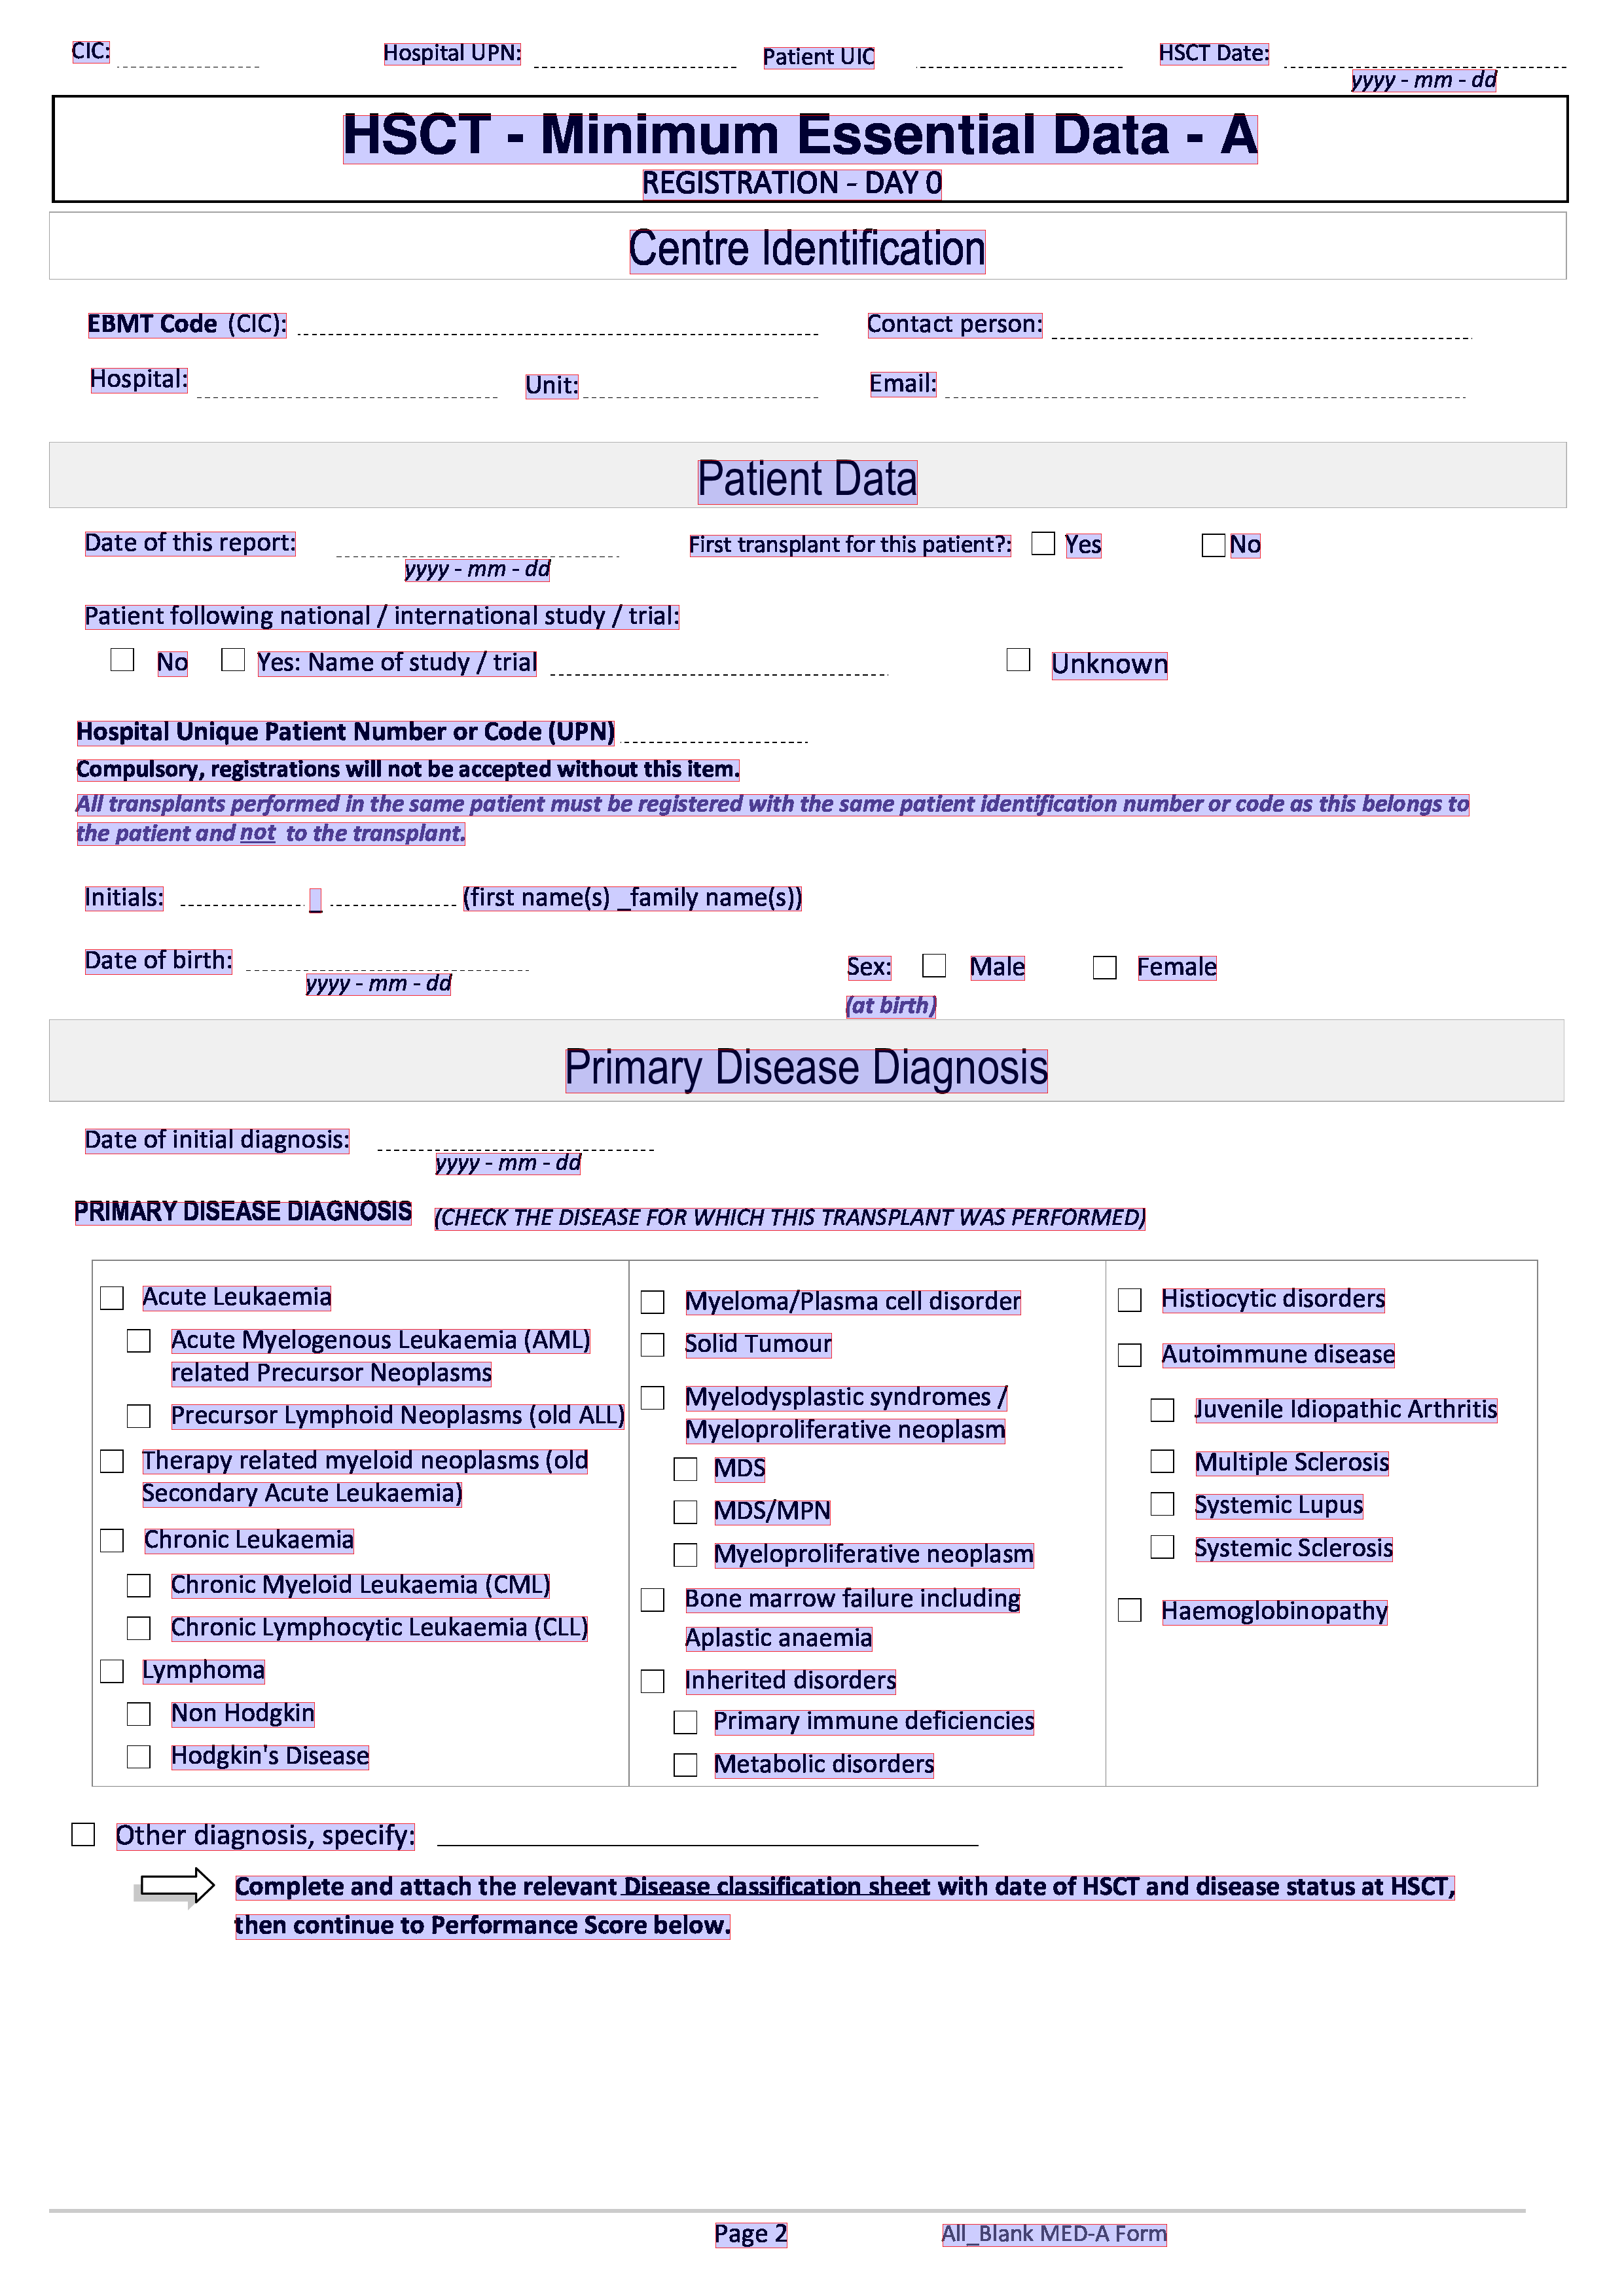

In [15]:
im = page.to_image(resolution=300)
im.draw_rects(combined_words)

## Checking checkboxes

In [72]:
import pandas as pd

words_df = pd.DataFrame(combined_words)

In [73]:
import json

with open('json/example_json_filling.json', 'r') as f:
    datas = json.load(f)

for data in datas:
    print(data['value'])

6655
12/10/2018
No
someone@gmail.com
Male


In [74]:
def write_txt(txt, exportLabel):
    val = words_df[words_df['text'].str.contains(exportLabel)]
    x=(float)(val['x1']) 
    y=(float)(page.bbox[3] - (val['bottom']))
    write_to_pdf(x,y,txt)
    


In [75]:
def write_date(txt):
    pass

In [76]:
import numpy as np

rects = page.rects
img = page.to_image(resolution=300)

def check_dist(exportLabel, val):
    rect_val_list = []
    
    exp = words_df[words_df['text'].str.contains(exportLabel)].values[0]
    exp_rect = (lookup_windowAround(exp))
    print(exp_rect)

    for x,i in enumerate(val):
       # print(i)
        rect_val = (lookup_windowAround(i))
        rect_val_list.insert(x, rect_val) 
        print(rectt)

    min_dist = 99999
    for i,rect_val in enumerate(rect_val_list):
        a = np.array((exp_rect['x0'],exp_rect['top']))
        b = np.array((rect_val['x0'],rect_val['top'] ))
        dist = np.linalg.norm(a-b)
        if(dist < min_dist):
            min_dist = dist
            index = i

    print("this is valindex")
    print(val[index])
    return val[index]

In [77]:
### CHECK CHECKBOX
### compare centers or top left corner
def write_checkbox(txt):
    rects = page.rects
    img = page.to_image(resolution=300)
    dataval = []
    aim_rects = []
    im = page.to_image()

  #  for data in datas:
      #  if(data['dataType'] == 'select'):
    
    val = words_df[words_df['text']== txt].values
    print(val)
    if (len(val) != 1): #if there are 2 same values
        v = check_dist(data['exportLabel'],val)
        aim_rect = lookup_windowAround(v) ## check here if close to exportlabel
        aim_rects.append(aim_rect)
        draw = im.draw_rect(lookup_windowAround(v))
        display(draw)
    else:
        v = val[0]
        print(v)
        aim_rect = lookup_windowAround(v)
        aim_rects.append(aim_rect)
        draw = im.draw_rect(lookup_windowAround(v))
        display(draw) 

    print(len(aim_rects))

    for aim_rect in aim_rects:
        for rect in rects:
            w = abs(rect['x1'] - rect['x0'])
            h = abs(rect['bottom'] - rect['top'])

            ### checking if box
            if abs(w-h) < 1 and w > 2:  ##if there is a checkbox inside the bounding box
                if((aim_rect['x0'] < rect['x0']) & (aim_rect['x1'] > rect['x1']) & (aim_rect['top'] < rect['top']) & (aim_rect['bottom'] > rect['bottom'])) :
                    print(rect)
                    y = (float)(page.bbox[3] - rect['bottom'])
                    x = (float)(rect['x0'])
                    write_to_pdf(x,y, "X")


                    img.draw_rect(rect, fill=(0,0,255,255), stroke_width=2)

    display(img)


In [23]:
words_df[words_df['text'].str.contains('Sex')].values[0]

array([Decimal('359.872'), 'Sex:', Decimal('349.864'), Decimal('310.550'),
       Decimal('327.143')], dtype=object)

In [24]:
acute = words_df[words_df['text'] == 'MDS/MPN'].values[0]

In [25]:
acute

array([Decimal('559.492'), 'MDS/MPN', Decimal('549.484'),
       Decimal('261.540'), Decimal('304.905')], dtype=object)

In [78]:
from decimal import Decimal

def lookup_windowAround(bbox):
    """
    returns a bigger bbox around text
    
    ## x0: left, x1:right
    """
    
    bottom,_,top,x0,x1 = bbox
    
    window = 20
    half_window = Decimal(window/2)
    twice_window = Decimal(window*2)
    
    
    rect_around = {'x0':x0-window, 'top':top-half_window, 'x1':x1+half_window, 'bottom':bottom+half_window,} #{'bottom:' : bottom-window, 'top:': top-window, 'x0:':x0-window, 'x1:':x1-window}
    
    return rect_around

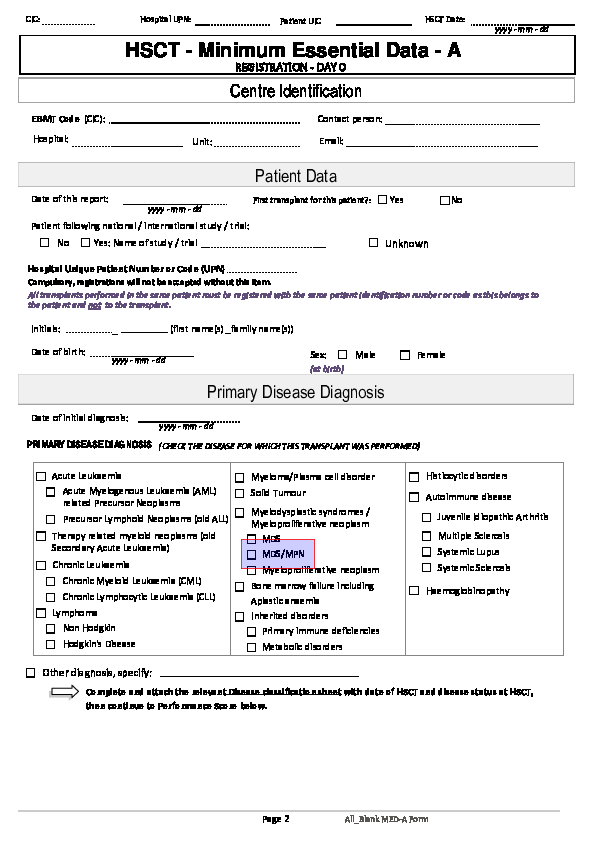

In [79]:
im = page.to_image()
aim_rect = lookup_windowAround(acute)
im.draw_rect(lookup_windowAround(acute))

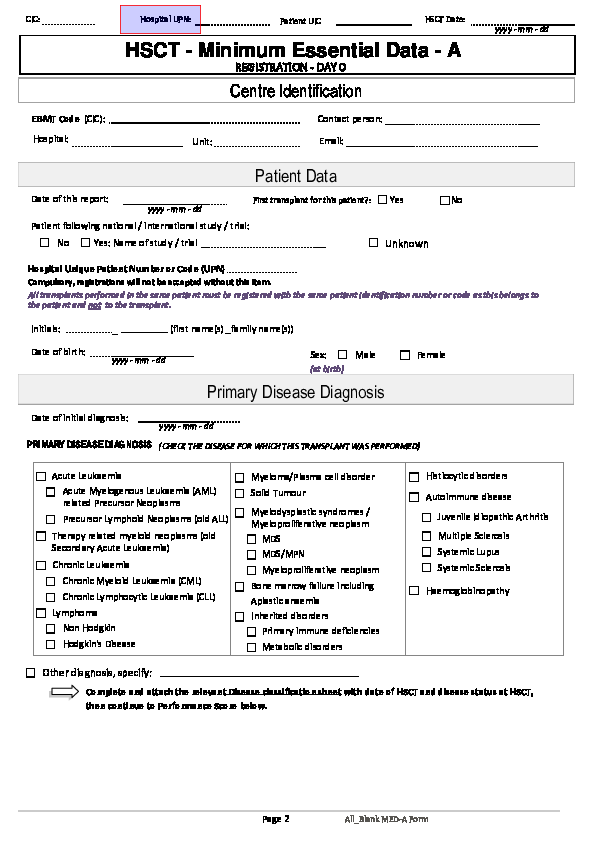

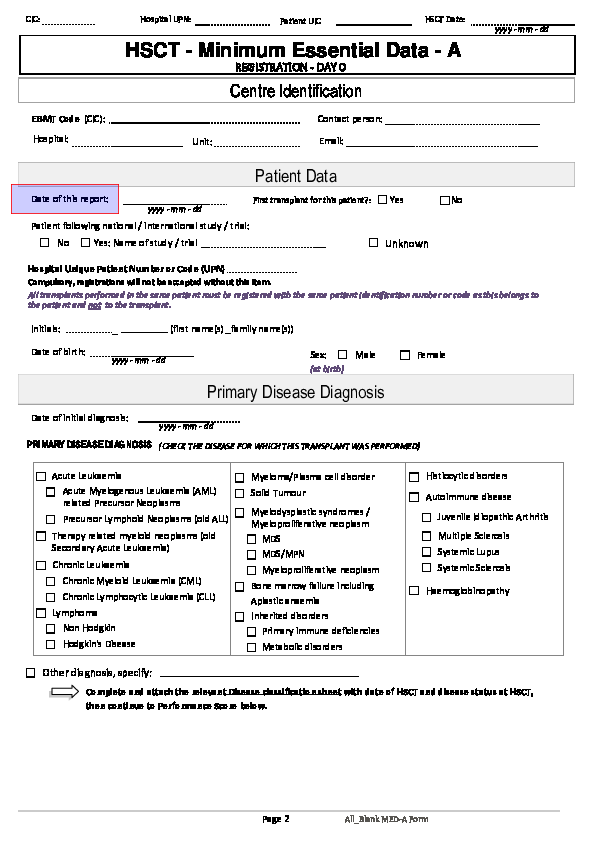

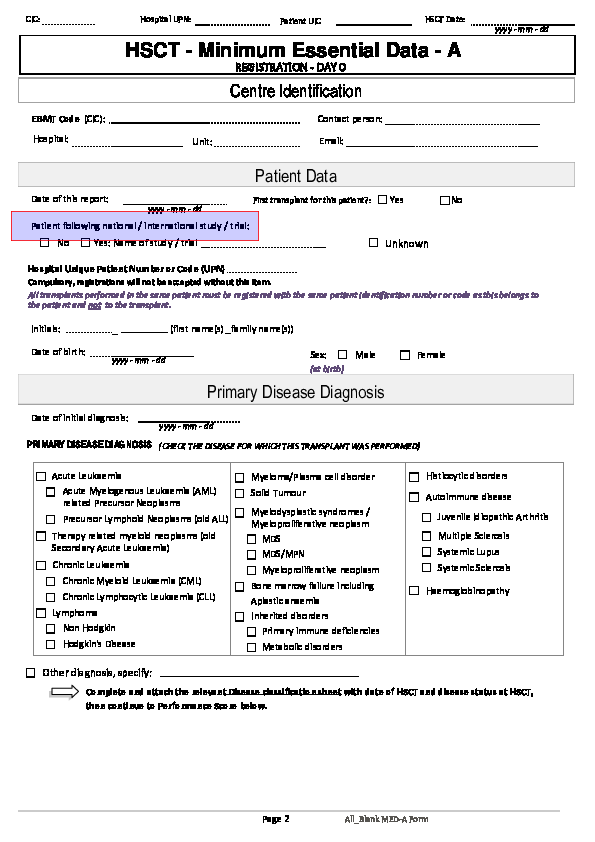

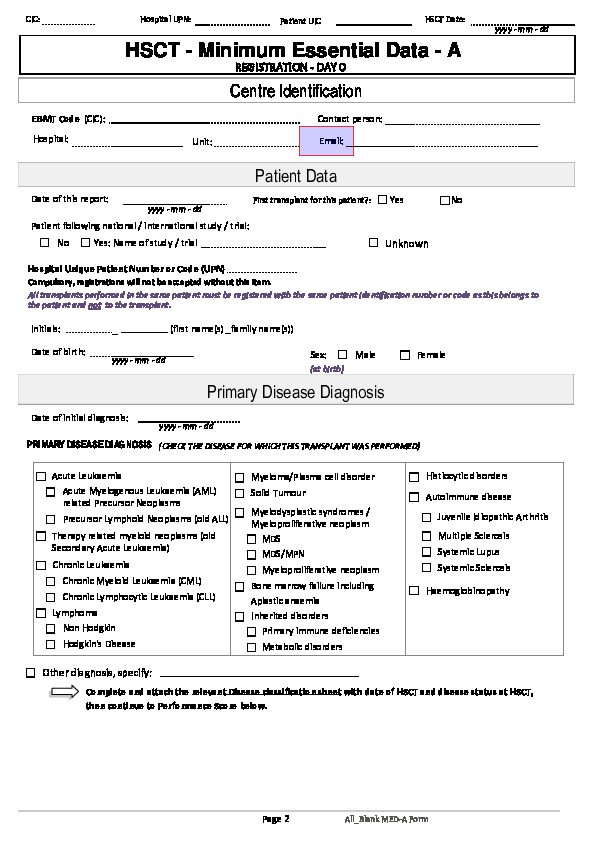

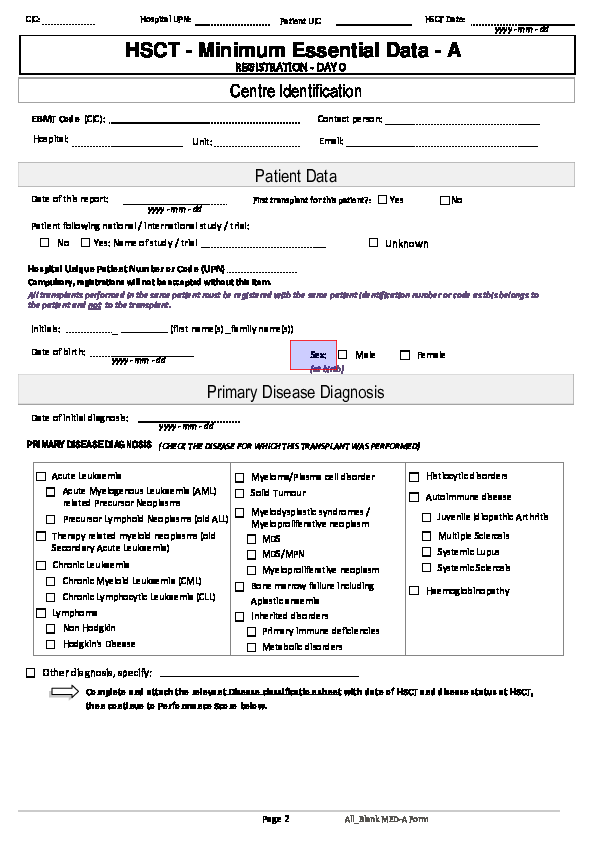

In [80]:

for data in datas:
    val = words_df[words_df['text'].str.contains(data['exportLabel'])].values[0]
    im = page.to_image()
    aim_rect = lookup_windowAround(val)
    draw = im.draw_rect(lookup_windowAround(val))
    display(draw)

### Write to PDF accordingly with coordinates

In [81]:
from PyPDF2 import PdfFileWriter, PdfFileReader
import io
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter

def write_to_pdf(x,y,val):
    packet = io.BytesIO()
   
    can = canvas.Canvas(packet, pagesize=letter)
    can.drawString(x, y, val)
    can.save()
   
    packet.seek(0)
    new_pdf = PdfFileReader(packet)

    existing_pdf = PdfFileReader(open("files/ex1.pdf", "rb"))
    output = PdfFileWriter()
    
    # decide on page
    page = existing_pdf.getPage(1)
    page.mergePage(new_pdf.getPage(0))
    output.addPage(page)
    
    # write output to new pdf
    outputStream = open("files/destination.pdf", "wb") ##CHECK OUTPUT ON THE NEW PDF!!!!
    output.write(outputStream)
    outputStream.close()

In [82]:
rects = page.rects
img = page.to_image(resolution=300)

[[Decimal('205.102') 'No' Decimal('195.094') Decimal('450.740')
  Decimal('462.558')]
 [Decimal('248.472') 'No' Decimal('238.464') Decimal('57.404')
  Decimal('69.222')]]
{'x0': Decimal('10.916'), 'top': Decimal('211.264'), 'x1': Decimal('259.381'), 'bottom': Decimal('241.272')}
{'x0': Decimal('430.740'), 'top': Decimal('185.094'), 'x1': Decimal('472.558'), 'bottom': Decimal('215.102')}
{'x0': Decimal('430.740'), 'top': Decimal('185.094'), 'x1': Decimal('472.558'), 'bottom': Decimal('215.102')}
this is valindex
[Decimal('248.472') 'No' Decimal('238.464') Decimal('57.404')
 Decimal('69.222')]


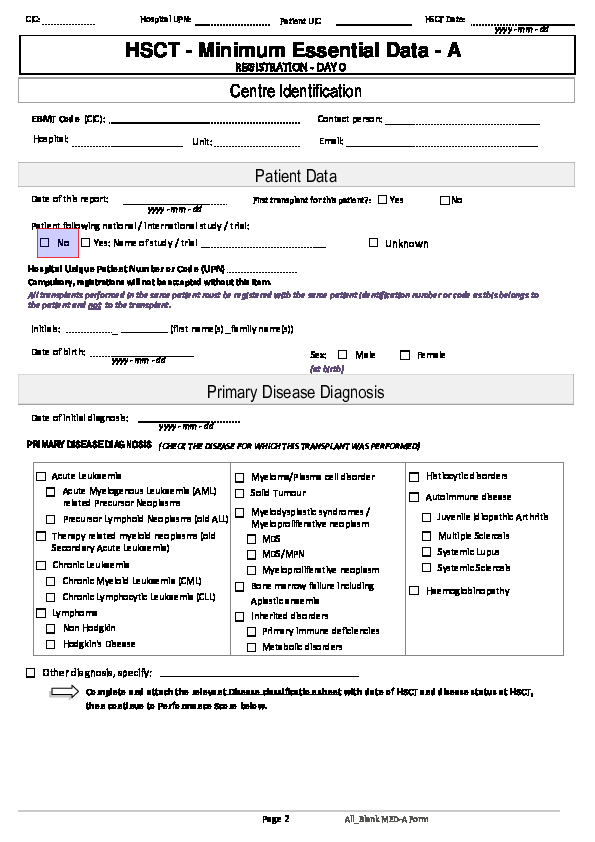

1
{'x0': Decimal('40.659'), 'y0': Decimal('595.760'), 'x1': Decimal('48.959'), 'y1': Decimal('603.979'), 'width': Decimal('8.300'), 'height': Decimal('8.219'), 'linewidth': Decimal('0.140'), 'stroke': Decimal('1'), 'fill': Decimal('1'), 'evenodd': Decimal('1'), 'stroking_color': None, 'non_stroking_color': None, 'object_type': 'rect', 'page_number': 2, 'top': Decimal('237.801'), 'bottom': Decimal('246.020'), 'doctop': Decimal('1079.581')}


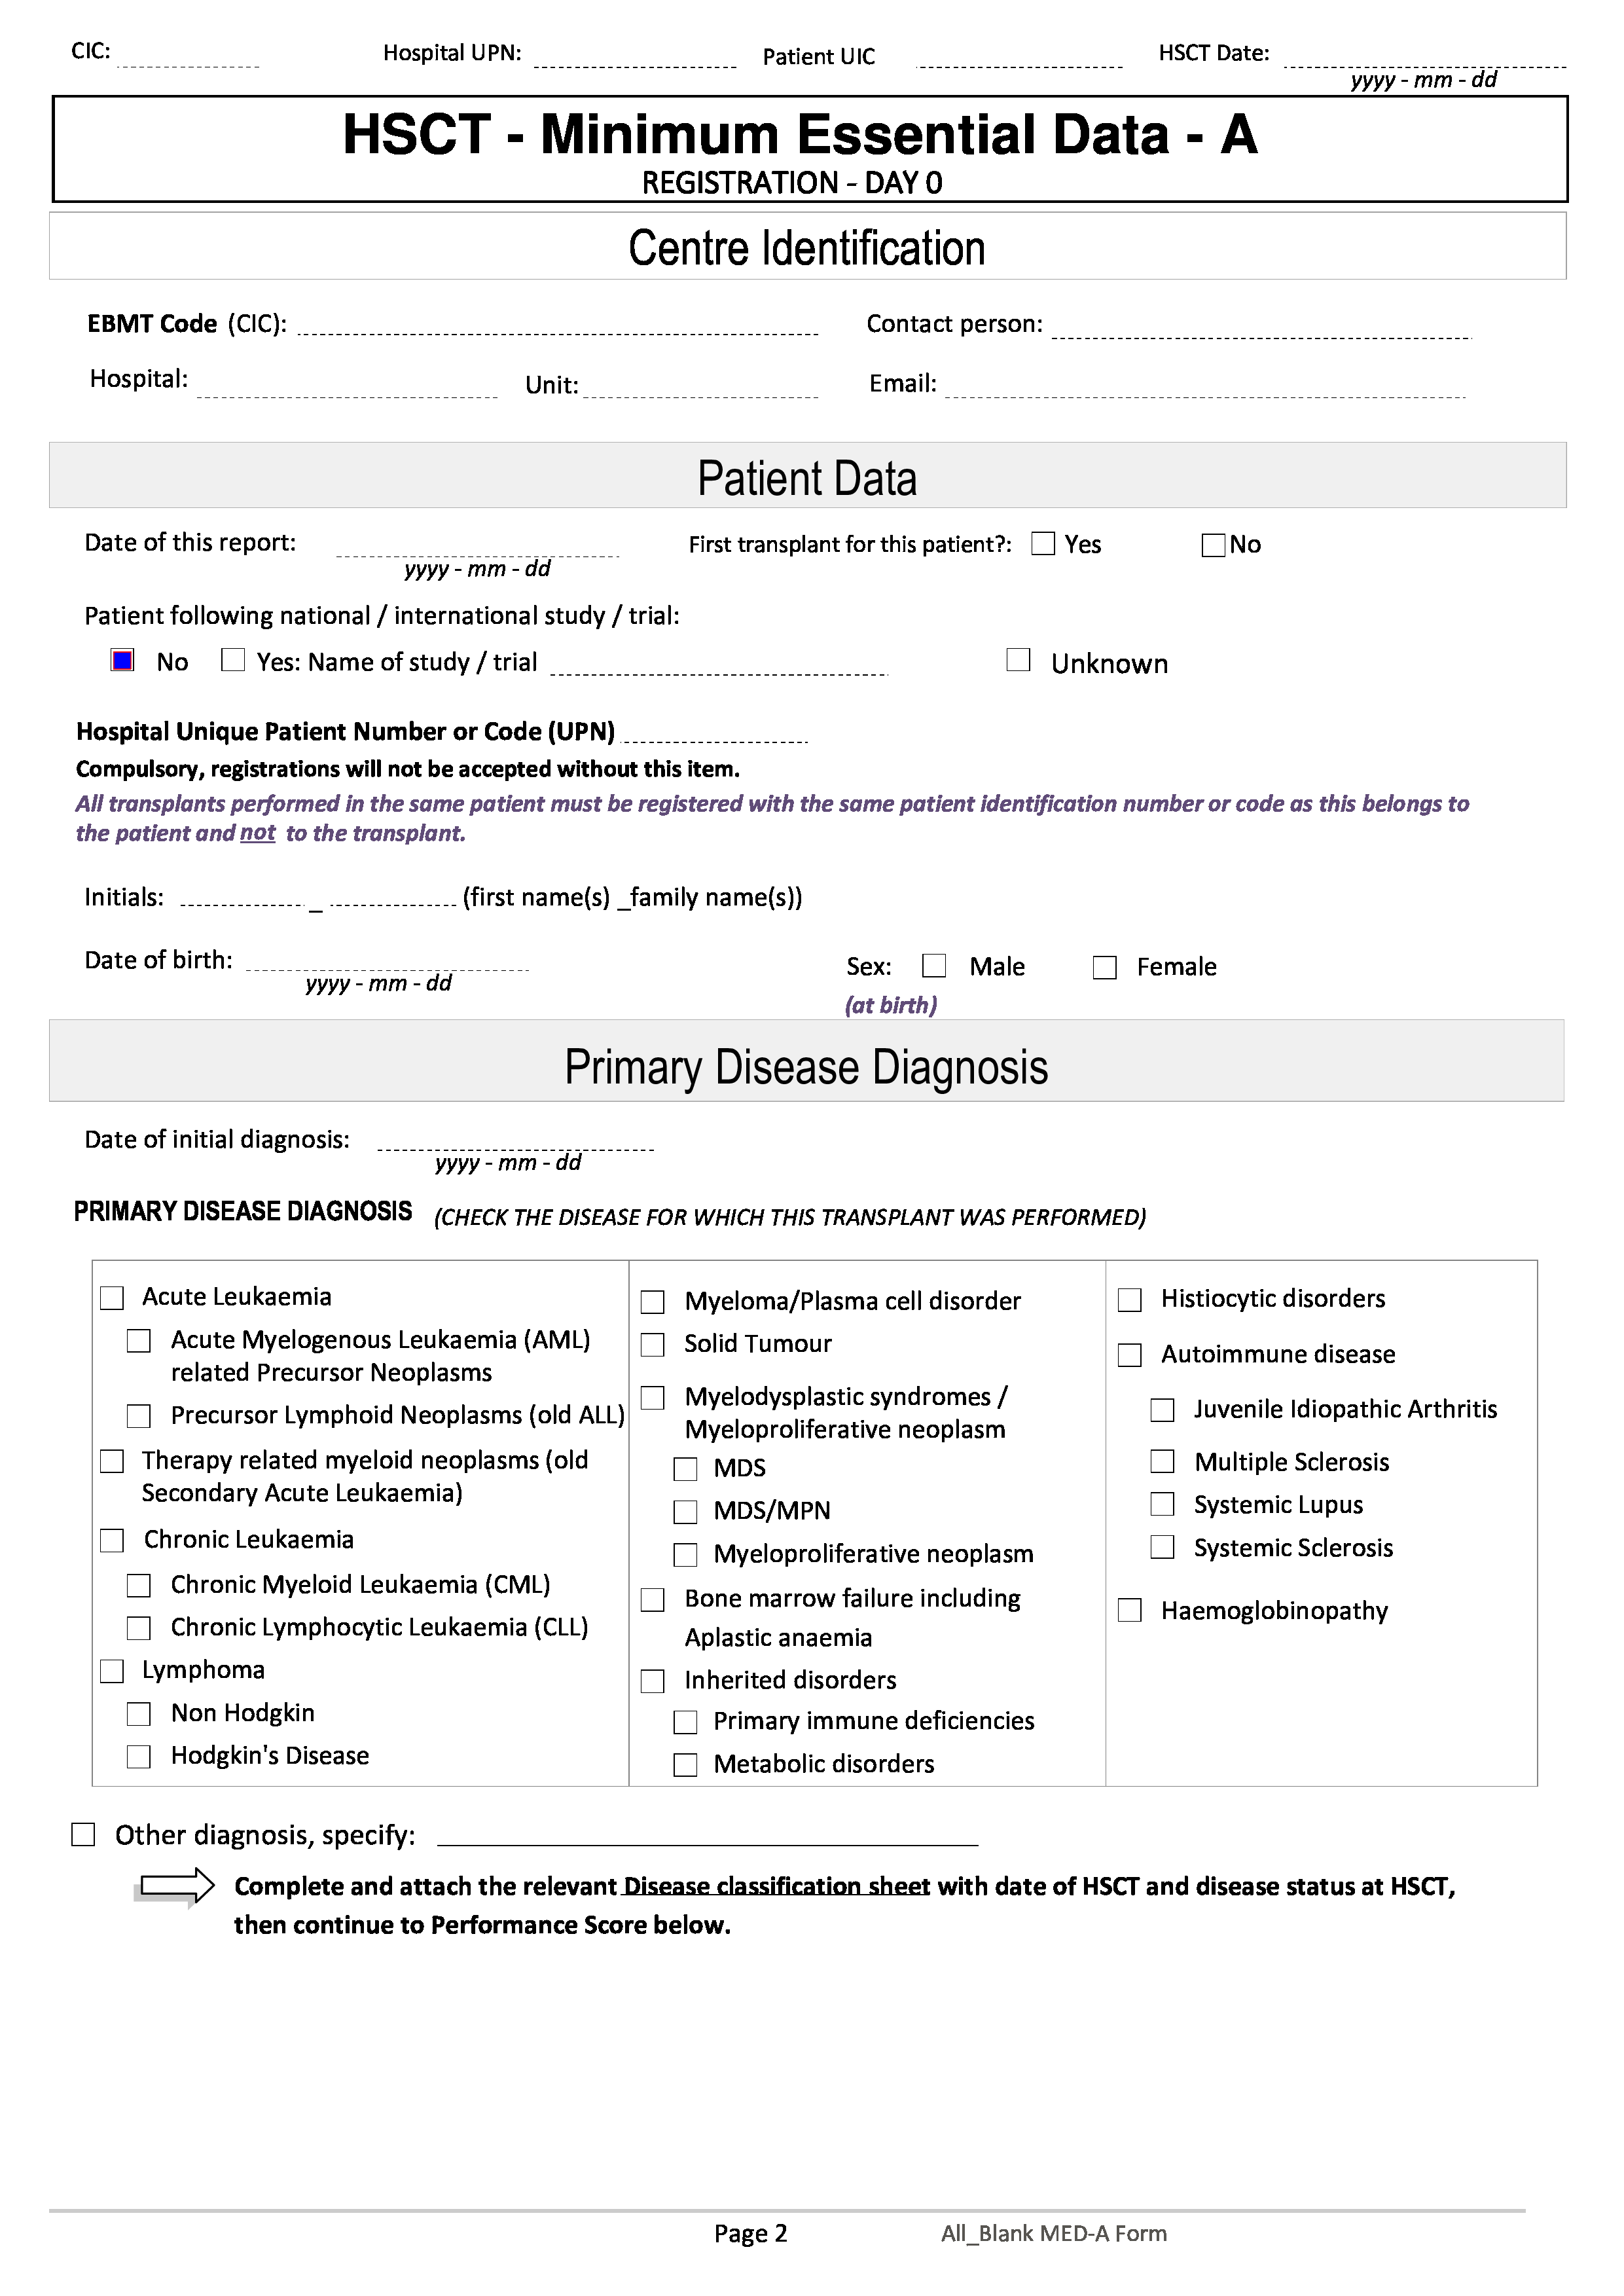

[[Decimal('359.872') 'Male' Decimal('349.864') Decimal('355.420')
  Decimal('376.077')]]
[Decimal('359.872') 'Male' Decimal('349.864') Decimal('355.420')
 Decimal('376.077')]


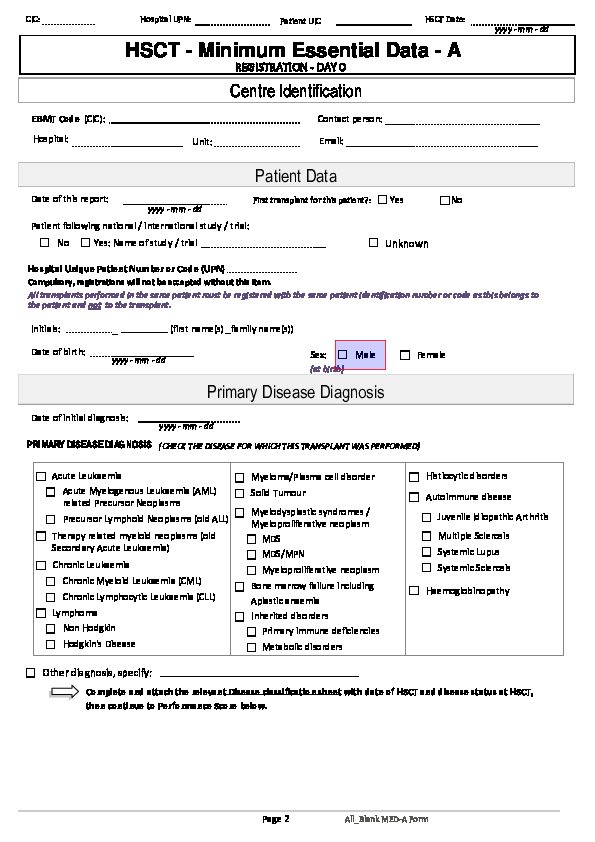

1
{'x0': Decimal('338.390'), 'y0': Decimal('483.600'), 'x1': Decimal('346.666'), 'y1': Decimal('491.843'), 'width': Decimal('8.276'), 'height': Decimal('8.243'), 'linewidth': Decimal('0.140'), 'stroke': Decimal('1'), 'fill': Decimal('1'), 'evenodd': Decimal('1'), 'stroking_color': None, 'non_stroking_color': None, 'object_type': 'rect', 'page_number': 2, 'top': Decimal('349.937'), 'bottom': Decimal('358.180'), 'doctop': Decimal('1191.717')}


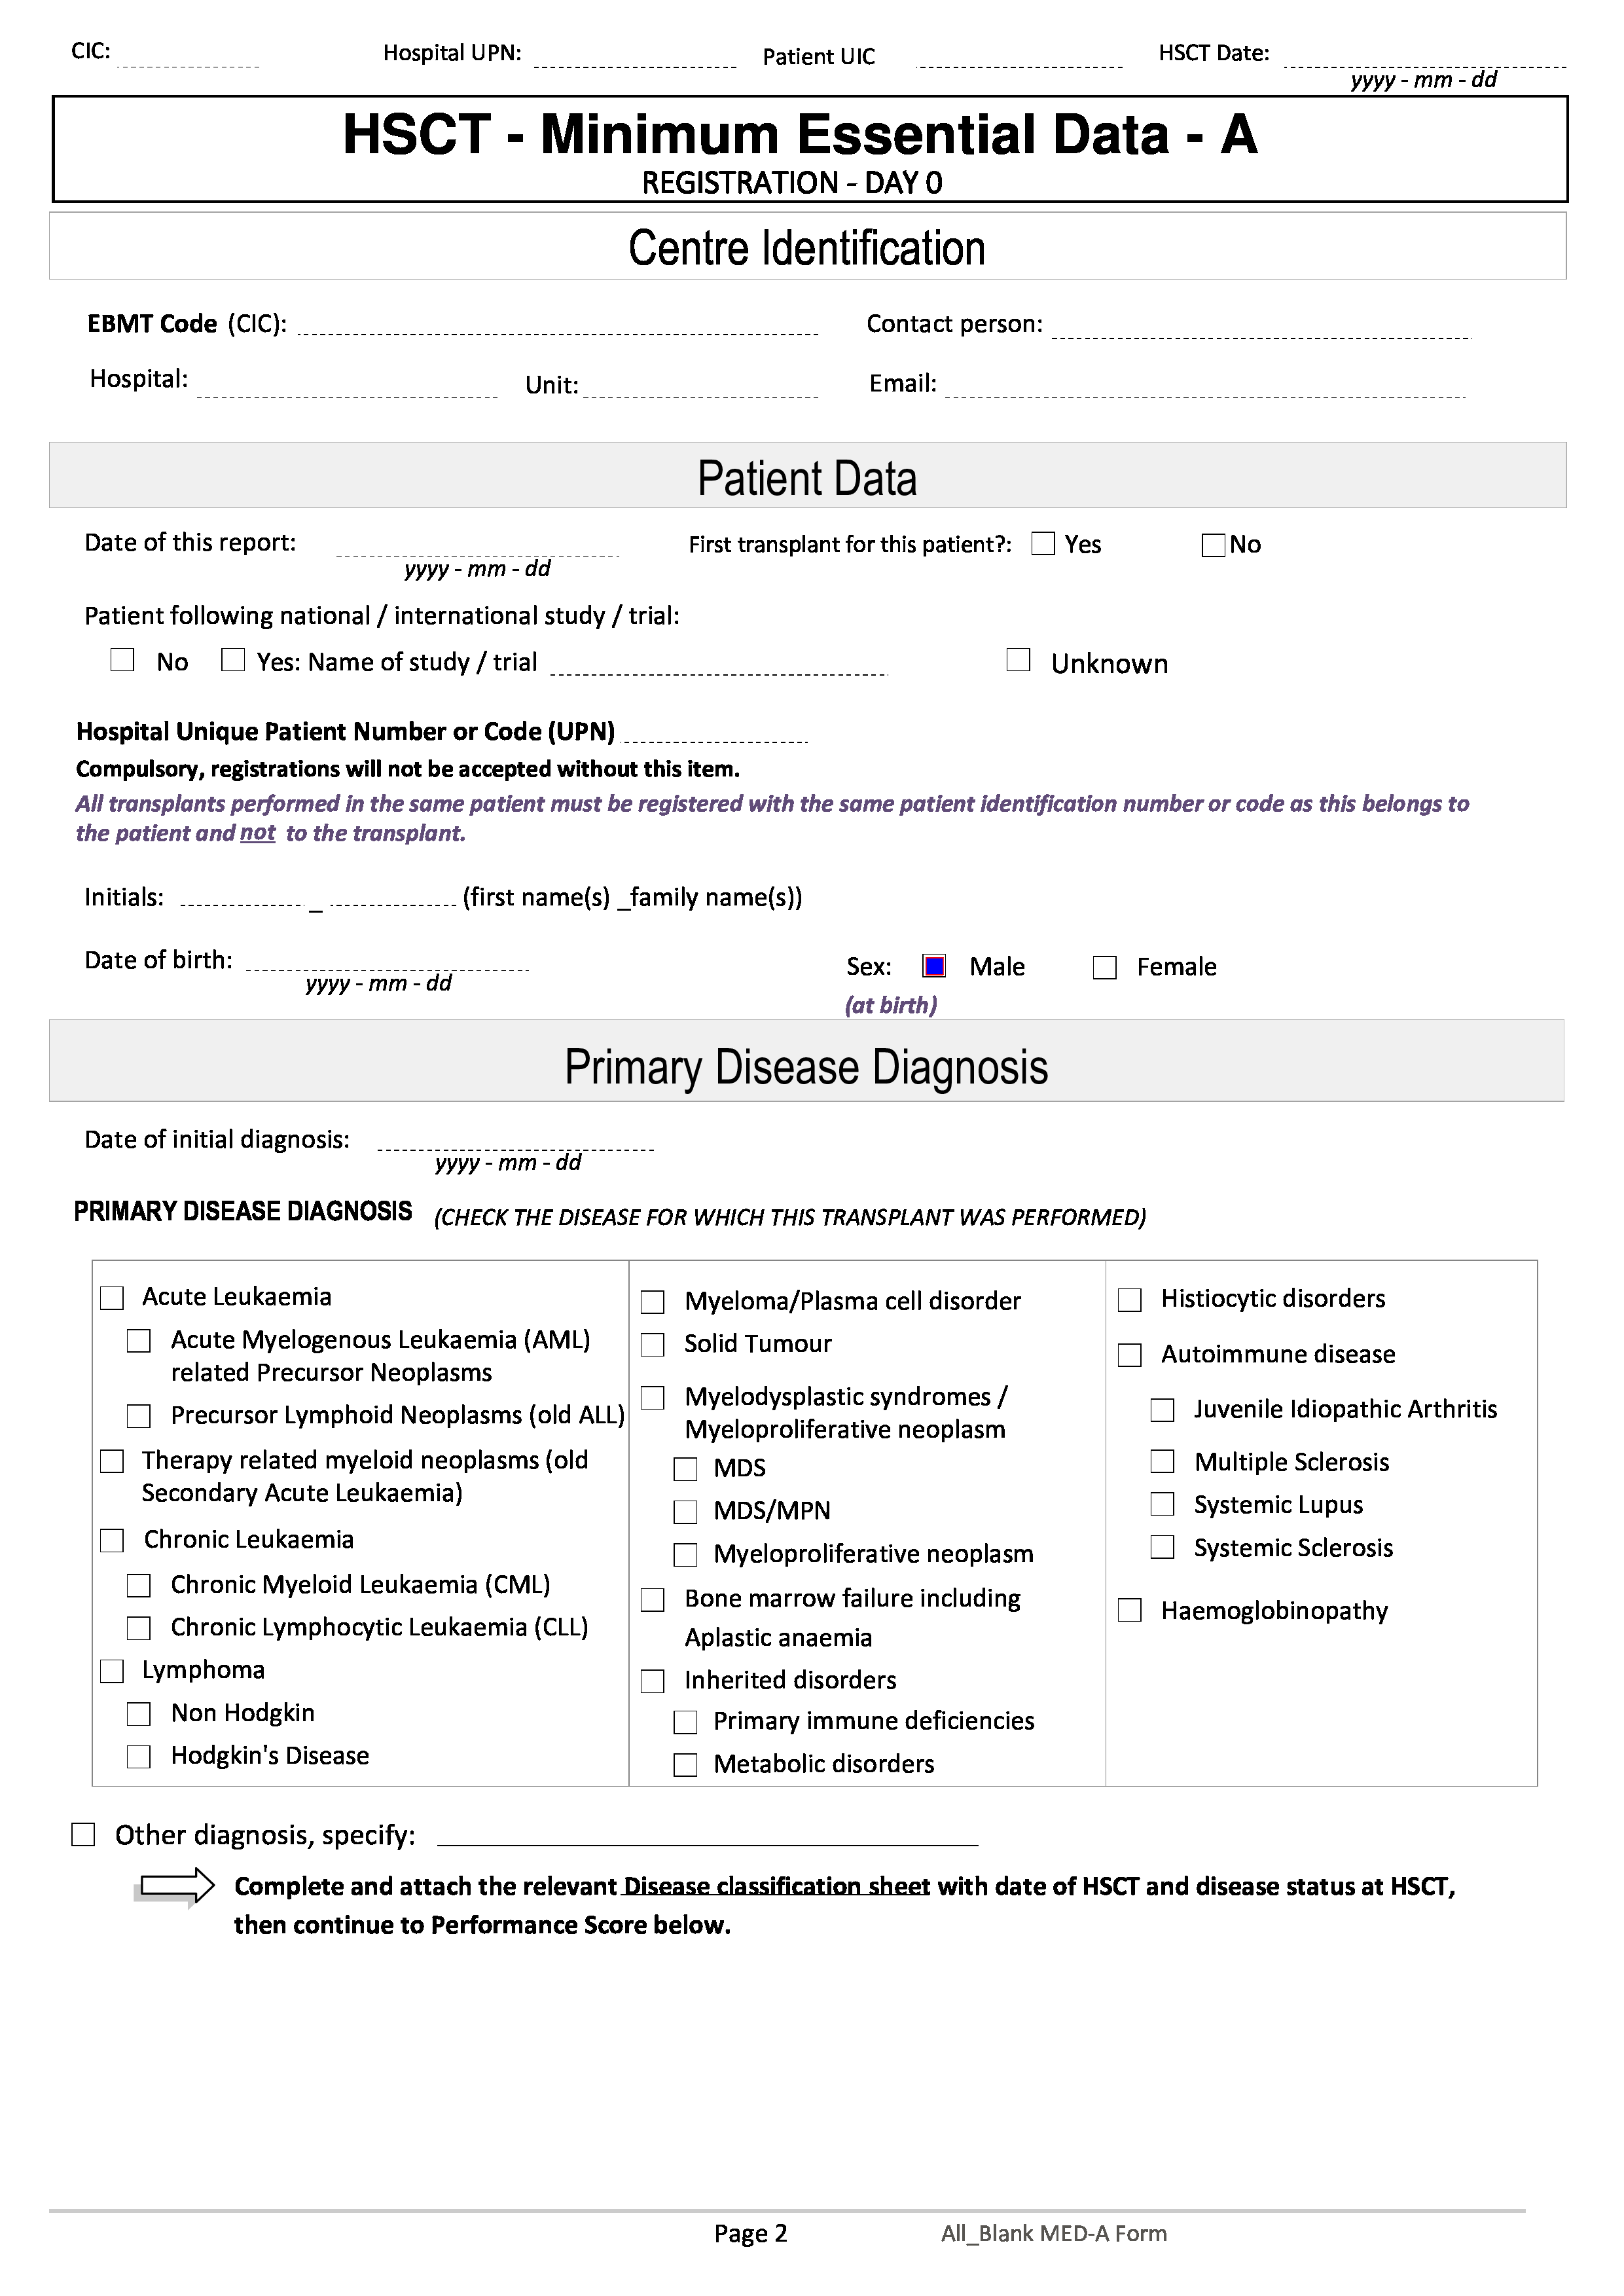

In [83]:
###TO DO FILL EACH WRITE METHOD ACCORDINGLY

for data in datas:
    if(data['dataType'] == 'text'):
        to_write = data['value']
        write_txt(to_write, data['exportLabel'])
    elif(data['dataType'] == 'date'):
        to_write = data['value']
        write_date(to_write)
    elif(data['dataType'] == 'select'):
        to_write = data['value']
        write_checkbox(to_write)